### Import libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import astropy.convolution as krn
import scipy.stats as stats
import seaborn as sns

from deepeye_analysis_package.plotting import makeHeat

In [15]:
def np_euclidean_distance(y_true, y_pred):
    """
    Compute the Euclidean distance between two sets of points.

    Parameters:
    -----------
    y_true : array-like
        True positions (ground truth).
    y_pred : array-like
        Predicted positions.

    Returns:
    --------
    numpy.ndarray
        Euclidean distances between corresponding points in y_true and y_pred.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.sum(np.square(y_pred - y_true), axis=-1))



### Preprocess files and make dataframe

test_all file contains the results of a validation session. If calibration had to be repeated under the same participant name, then the results of the new validation are appended. Therefore, the test_all file may contain several validation datasets, each with each own header row. 


1. Extract the last dataset from the test_all file based on the header row
2. Label 25-dot dataset based on 9-dot calibration as 25_9, and on 13-dot calibration as 25_13
3. Participants had 3 attempts to get calibration <3 cm. Keep only the successful calibration dataset (total=4)
4. Scale pixels to standard dimensions. Calibration dots were presented as % display size in px
5. Convert pixels to cm
6. Assign each dot a unique label



In [16]:
# Path to data folders
# path_to_folders = 'D:/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/data'
path_to_folders = 'C:/Users/aby600/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/data'

# Get all folder names
folder_names = os.listdir(path_to_folders)

# List to accumulate datasets across subjects
pp_list = []

# Define target resolution, since datasets may have different screen resolutions
TARG_RES = True
if TARG_RES:
    target_resX, target_resY = 1920, 1080
else:
    target_resX, target_resY = None, None

# Define numeric columns for conversion
numeric_columns = ['numCalibDots', 'x', 'y', 'user_pred_px_x', 'user_pred_px_y', 'scrW_cm', 'resX', 'resY']

for fn in folder_names:
    path = os.path.join(path_to_folders, fn, f"{fn}_test_all.csv")
    
    try:
        # Read the file into a DataFrame without assuming headers
        df = pd.read_csv(path, header=None)
    except Exception:
        continue

    # Identify duplicate rows, which likely represent header rows
    header_indices = df.index[df.duplicated(keep=False)].tolist()

    # Extract the dataset after the last duplicated header, if any
    if header_indices:
        last_dataset = df.iloc[header_indices[-1]:].reset_index(drop=True)
        last_dataset.columns = last_dataset.iloc[0]  # Set column names from the first row after the header
        last_dataset = last_dataset[1:]  # Remove header row
    else:
        # If no additional headers, use the entire dataset with the first row as column names
        last_dataset = df
        last_dataset.columns = last_dataset.iloc[0]
        last_dataset = last_dataset[1:]

    # Reset column headers and convert specified columns to numeric, coercing errors
    last_dataset = last_dataset.reset_index(drop=True)
    last_dataset[numeric_columns] = last_dataset[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Drop rows where 'numCalibDots' is NaN and convert to integer
    last_dataset.dropna(subset=['numCalibDots'], inplace=True)
    last_dataset['numCalibDots'] = last_dataset['numCalibDots'].astype(int)
    

    # Calculate Euclidean distance in pixels and centimeters
    last_dataset['eucl_dist_px_orig'] = np.linalg.norm(
        last_dataset[['x', 'y']].to_numpy() - last_dataset[['user_pred_px_x', 'user_pred_px_y']].to_numpy(), axis=1
    )
    last_dataset['scale_cm_in_px'] = last_dataset['scrW_cm'] / last_dataset['resX']
    last_dataset['eucl_dist_cm_orig'] = last_dataset['eucl_dist_px_orig'] * last_dataset['scale_cm_in_px']

    # Define target resolution for scaling not provided, take the first resolution in the dataset
    if not TARG_RES:
        target_resX, target_resY = last_dataset['resX'].iloc[0], last_dataset['resY'].iloc[0]

    # Scale coordinates
    last_dataset['user_pred_px_x_scaled'] = last_dataset['user_pred_px_x'] / last_dataset['resX'] * target_resX
    last_dataset['user_pred_px_y_scaled'] = last_dataset['user_pred_px_y'] / last_dataset['resY'] * target_resY
    last_dataset['x_scaled'] = np.round(last_dataset['x'] / last_dataset['resX'] * target_resX)
    last_dataset['y_scaled'] = np.round(last_dataset['y'] / last_dataset['resY'] * target_resY)

    # Identify unique dot positions
    unique_dots, indices = np.unique(last_dataset[['x_scaled', 'y_scaled']], axis=0, return_inverse=True)
    last_dataset['unique_dot'] = indices

    # Identify unique dot positions
    unique_dots = last_dataset[['x_scaled', 'y_scaled']].drop_duplicates()

    # Filter out participants if they have fewer unique dots than the number in 'numCalibDots'
    required_dots = last_dataset['numCalibDots'].iloc[0]
    if len(unique_dots) < required_dots:
        print(f"Skipping participant {fn} with fewer unique dots ({len(unique_dots)}) than required ({required_dots})")
        continue  # Skip this participant if they have fewer unique dots

    # Add subject identifier
    last_dataset['subj_nr'] = fn

    # Append the cleaned dataset to the list
    pp_list.append(last_dataset)

# Concatenate all subject data into a single DataFrame
all_df = pd.concat(pp_list, ignore_index=True)


Skipping participant 2024_02_19_10_25_11 with fewer unique dots (6) than required (9)
Skipping participant 2024_03_11_14_14_36 with fewer unique dots (8) than required (9)


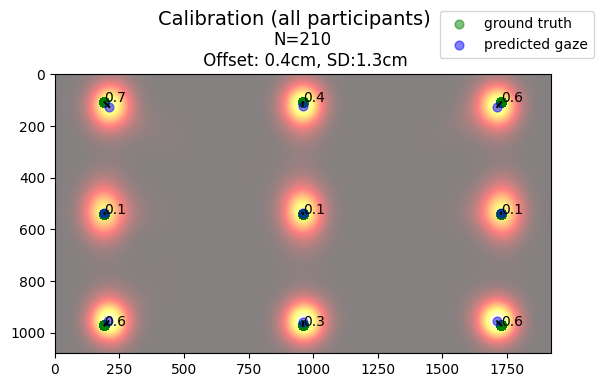

In [17]:
def plot_all_dots(df, target_resX, target_resY):
    # Make heatmap of all gaze points of all subjects
    heatmap = makeHeat([target_resX, target_resY], np.array(df.user_pred_px_x_scaled), np.array(df.user_pred_px_y_scaled))    
    
    # Get median gaze prediction per dot
    median_pred_x = df.groupby('unique_dot').user_pred_px_x_scaled.median()
    median_pred_y = df.groupby('unique_dot').user_pred_px_y_scaled.median()  
             
    # Get ground truth per each dot
    true_x = df.groupby('unique_dot').x_scaled.mean()
    true_y = df.groupby('unique_dot').y_scaled.mean()   
        
    # calculate the distance between median gaze prediction to ground truth per each dot
    offset = np_euclidean_distance(np.array([median_pred_x, median_pred_y]).T, np.array([true_x, true_y]).T)    
   
    # Convert to cm
    offset_cm = offset *  df.scale_cm_in_px[0]
    
    # Compute SD   
    median_pred = df.groupby('unique_dot')[['user_pred_px_x_scaled','user_pred_px_y_scaled']].median()
    median_pred.columns = ['median_pred_x', 'median_pred_y'] 
    # Add median prediction per dot into the original df
    df = pd.merge(df, median_pred, on="unique_dot", how="left")
    
    # Compute euclidean distance from each gaze sample to median gaze for each dot  
    df['eucl_dist_gaze_to_median_px'] = np_euclidean_distance(np.array([df.user_pred_px_x_scaled, df.user_pred_px_y_scaled]).T, 
                                                             np.array([df.median_pred_x, df.median_pred_y]).T)
    
    # Average e.d. for each dot
    SD = df.groupby('unique_dot').eucl_dist_gaze_to_median_px.mean()
    SD_cm = SD * df.scale_cm_in_px[0]
    
   
    # Plot heatmap for current condition
    plt.figure()

    plt.imshow(heatmap, cmap=cm.hot, extent=[0, target_resX, target_resY, 0], alpha = 0.5, aspect='equal')  
    # Plot true pos and predicted median errors, lines
    plt.scatter(df.x_scaled, df.y_scaled, c='g', s=40, alpha=0.5, label='ground truth')
    plt.scatter(median_pred_x, median_pred_y, c='b', s=40, alpha=0.5, label='predicted gaze')
    plt.plot([median_pred_x, true_x], [median_pred_y, true_y], c='black')
    # Title
    # df['subj_nr'] = 1
    plt.title(f'N={df.subj_nr.unique().size}\n Offset: {np.round(offset_cm.mean(),1)}cm, SD:{np.round(SD_cm.mean(),1)}cm')
    
    # Plot offset values for each dot
    for x,y,e in zip(np.array(true_x), np.array(true_y), np.round(offset_cm, 1)):
        plt.text(x, y, e, fontsize=10)
    
   
    # Save plot
    plt.suptitle(f'Calibration (all participants)', fontsize=14)
    plt.subplots_adjust(top=1.0)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1,1.25))
    # fig2.savefig('calibration.jpg', dpi=1000, pad_inches=0)

plot_all_dots(all_df, target_resX, target_resY)


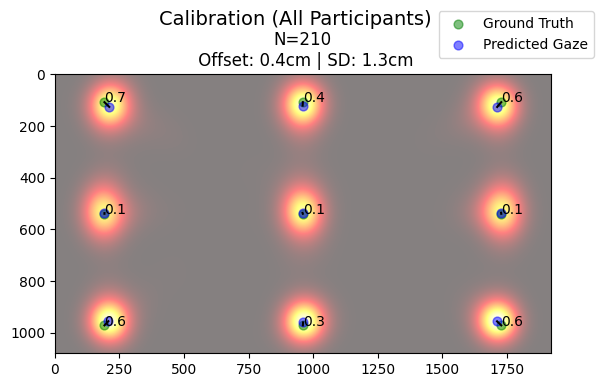

In [18]:
def plot_all_dots(df):
    # Generate heatmap for all gaze points
    heatmap = makeHeat([target_resX, target_resY], df['user_pred_px_x_scaled'].values, df['user_pred_px_y_scaled'].values)
    
    # Calculate median gaze predictions and ground truth per dot
    median_pred = df.groupby('unique_dot')[['user_pred_px_x_scaled', 'user_pred_px_y_scaled']].median()
    median_pred.columns = ['median_pred_x', 'median_pred_y']
    
    true_pos = df.groupby('unique_dot')[['x_scaled', 'y_scaled']].mean()
    
    # Calculate offset between median gaze predictions and ground truth, then convert to cm
    offset_px = np.linalg.norm(median_pred.values - true_pos.values, axis=1)
    offset_cm = offset_px * df['scale_cm_in_px'].iloc[0]
    
    # Calculate Euclidean distance from each gaze point to the median prediction for each dot
    df = df.merge(median_pred, on='unique_dot', how='left')

    df['eucl_dist_gaze_to_median_px'] = np.linalg.norm(
        df[['user_pred_px_x_scaled', 'user_pred_px_y_scaled']].values - df[['median_pred_x', 'median_pred_y']].values,
        axis=1
    )    
    
    # Calculate the mean Euclidean distance per dot and convert to cm for standard deviation (SD)
    SD_px = df.groupby('unique_dot')['eucl_dist_gaze_to_median_px'].mean()
    SD_cm = SD_px * df['scale_cm_in_px'].iloc[0]

    # Plot heatmap and ground truth vs. predicted gaze points
    plt.figure()
    plt.imshow(heatmap, cmap=cm.hot, extent=[0, target_resX, target_resY, 0], alpha=0.5, aspect='equal')
    
    # Plot ground truth positions (green) and median predicted gaze (blue)
    plt.scatter(true_pos['x_scaled'], true_pos['y_scaled'], c='g', s=40, alpha=0.5, label='Ground Truth')
    plt.scatter(median_pred['median_pred_x'], median_pred['median_pred_y'], c='b', s=40, alpha=0.5, label='Predicted Gaze')
    
    # Draw lines between ground truth and predictions for visualizing offsets
    plt.plot([median_pred['median_pred_x'], true_pos['x_scaled']], [median_pred['median_pred_y'], true_pos['y_scaled']], c='black')
            
    # Title and statistics in the legend
    plt.title(f'N={df["subj_nr"].nunique()}\n Offset: {offset_cm.mean():.1f}cm | SD: {SD_cm.mean():.1f}cm', fontsize=12)
    
    # Annotate offset values near each ground truth dot position
    for (x, y, e) in zip(true_pos['x_scaled'], true_pos['y_scaled'], offset_cm.round(1)):
        plt.text(x, y, str(e), fontsize=10, color='black')
    
    # Add legend and final touches
    plt.suptitle('Calibration (All Participants)', fontsize=14)
    plt.subplots_adjust(top=1.0)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.25))
    
    # Show the plot
    plt.show()

# Call the function with the dataframe
plot_all_dots(all_df)


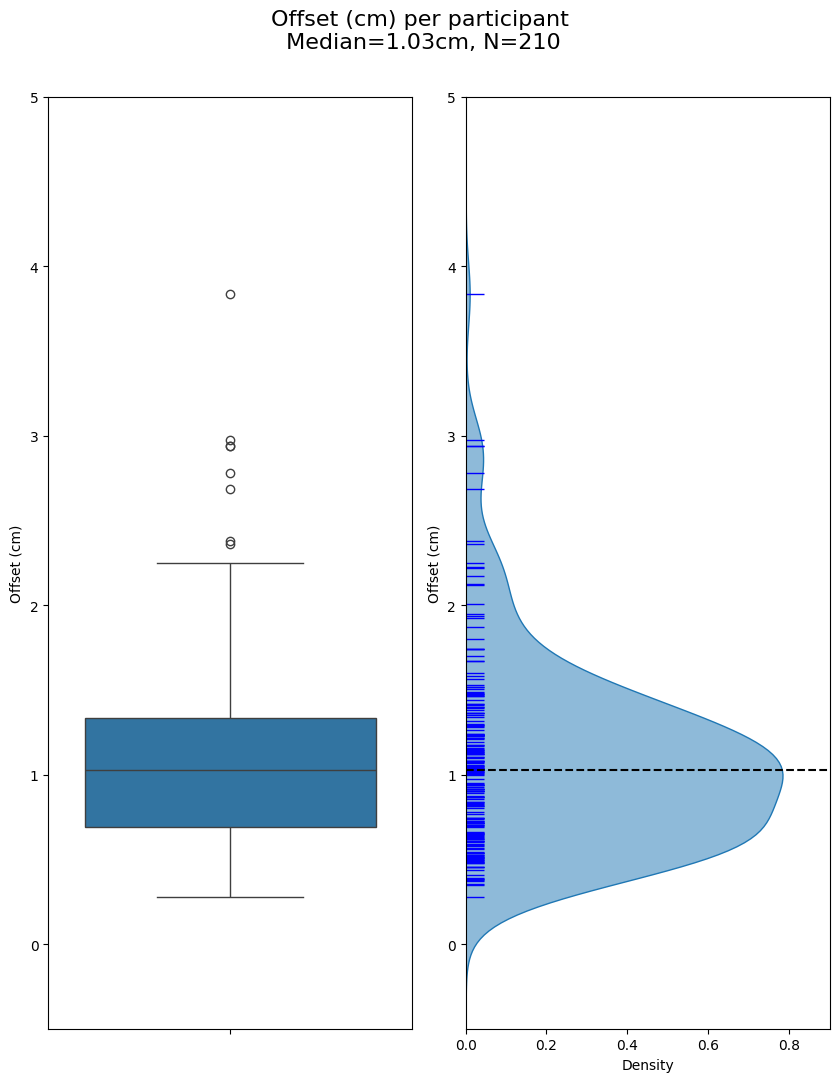

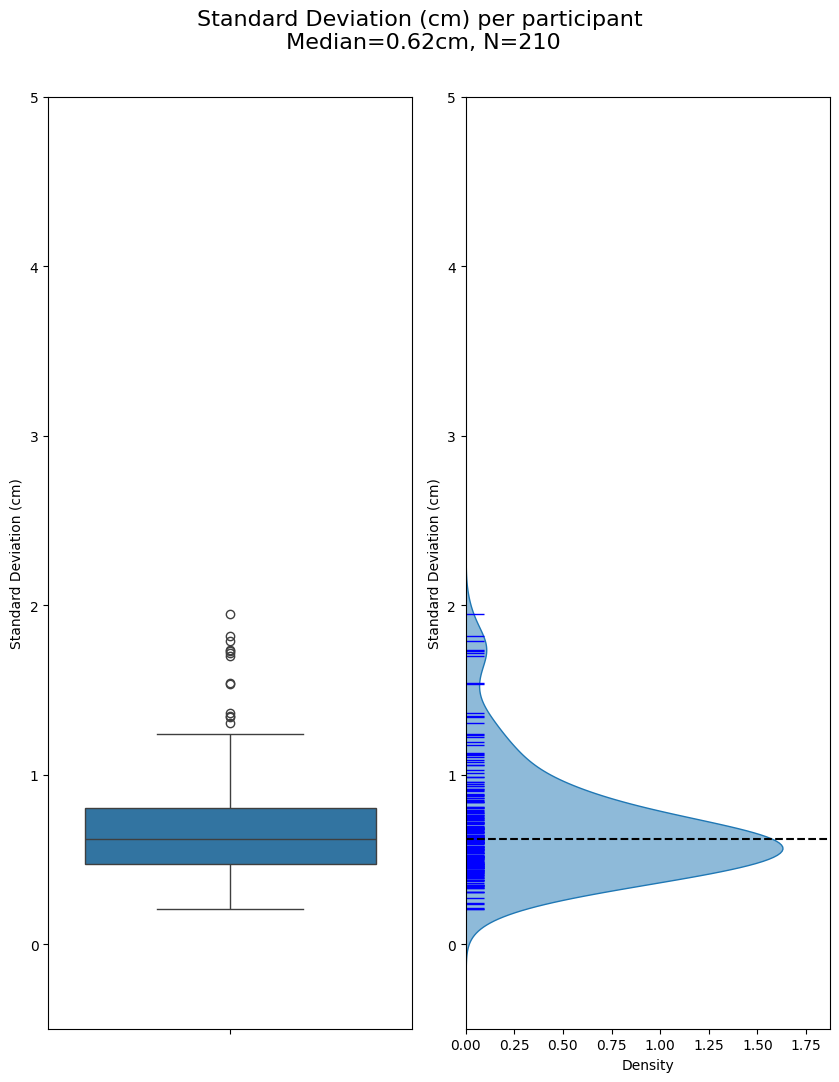

In [19]:
# def plot_offset_SD_per_participant(measurement, name=''):

#     fig, ax = plt.subplots(nrows=1, ncols=2)
#     fig.set_size_inches((8.5, 11), forward=False)

#     sns.kdeplot(y=measurement, ax=ax[1], fill=True, alpha=0.5)
#     # Plot individual points
#     sns.rugplot(y=measurement, ax=ax[1], height=0.05, color="b")
#     median_data = measurement.median()
#     plt.axhline(median_data, color='k', linestyle='--', linewidth=1.5, label=f'Median: {median_data:.2f}')
    
    
#     sns.boxplot(y=measurement, ax=ax[0])
    
#     ax[0].set_ylim(-0.5,5)
#     ax[1].set_ylim(-0.5,5)

#     # Save plot   
#     fig.suptitle(f'{name} per participant\n Median={median_data:.2f}cm, N={all_df.subj_nr.unique().size}', fontsize=16)
#     ax[0].set_ylabel(name)
#     ax[1].set_ylabel(name)

#     fig.tight_layout()    
#     fig.subplots_adjust(top=0.9)
#     # fig.savefig('summary.jpg', dpi=1000)


# # Loop thru each condition
# count_plots = 0
# summary_df_all = []


    
# # df for all subjects for each condition
# summary_df = []    

# # Loop thru each subject and unique dot
# for _, j in all_df.groupby(['subj_nr', 'unique_dot']):
    
#     # Get median gaze for each unique dot in pixels
#     j['median_pred_x'] = j.user_pred_px_x_scaled.median()
#     j['median_pred_y'] = j.user_pred_px_y_scaled.median()
    
#     # Get euclidean distance from each gaze sample to median gaze for each dot
#     j['eucl_dist_gaze_to_median_px'] = np_euclidean_distance(np.array([j.user_pred_px_x_scaled, j.user_pred_px_y_scaled]).T, 
#                             np.array([j.median_pred_x, j.median_pred_y]).T)        
#     j['eucl_dist_gaze_to_median_cm'] = j.eucl_dist_gaze_to_median_px * all_df.scale_cm_in_px.iloc[0]
    
#     # Get euclidean distance from median gaze to ground truth (accuracy)
#     j['offset_px'] = np_euclidean_distance(np.array([j.median_pred_x, j.median_pred_y]).T, np.array([j.x_scaled, j.y_scaled]).T)  
#     j['offset_cm'] = j.offset_px * all_df.scale_cm_in_px.iloc[0]
    
#     summary_df.append(j)        

# # Concatenate datasets from all subjects  
# summary_df = pd.concat(summary_df)

# # Get STD (mean distance of gaze_to_median per subject)
# agg_SD = summary_df.groupby(['subj_nr'])[['eucl_dist_gaze_to_median_cm']].mean().reset_index()

# # Get offset
# agg_OFFSET = summary_df.groupby(['subj_nr'])[['offset_cm']].mean().reset_index()

# # Plot offset per subject 
# plot_offset_SD_per_participant(agg_OFFSET.offset_cm, name='Offset (cm)')

# # Plot SD per subject
# plot_offset_SD_per_participant(agg_SD.eucl_dist_gaze_to_median_cm, name='Standard Deviation (cm)')
    


# # accumulate all dfs across conditions
# summary_df_all.append(summary_df)

# # Concatenate datasets across conditions
# summary_df_all = pd.concat(summary_df_all)
    



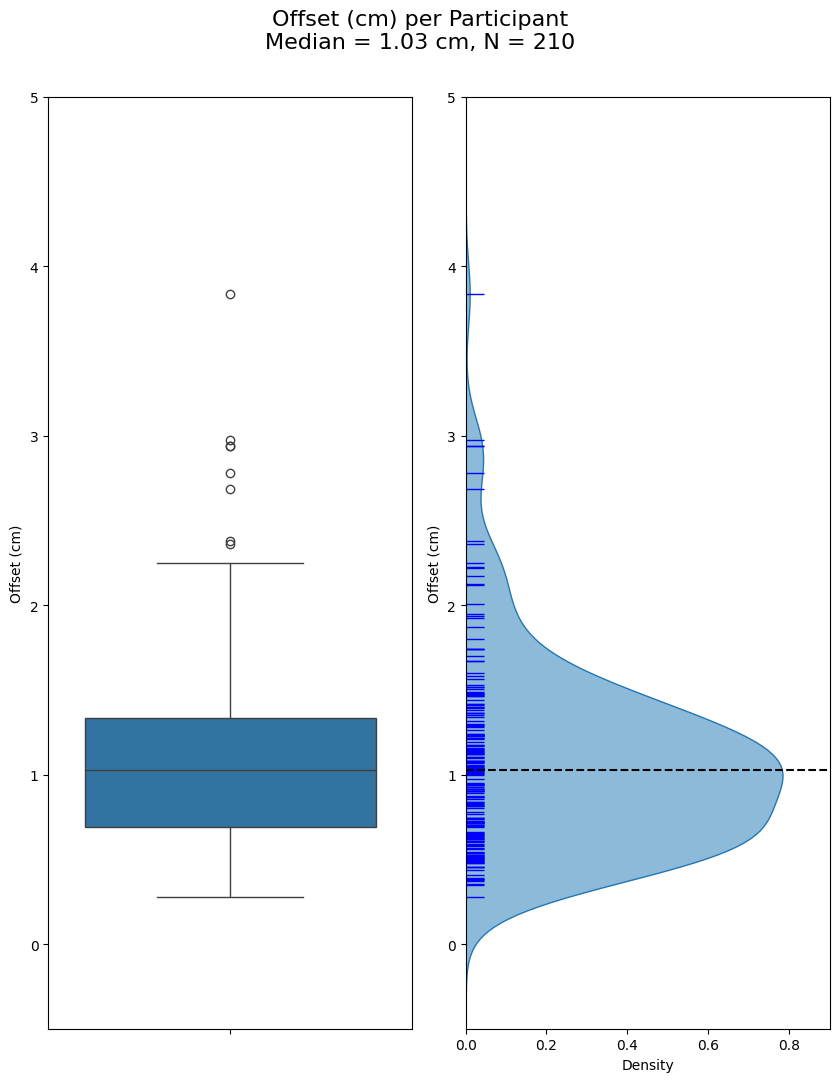

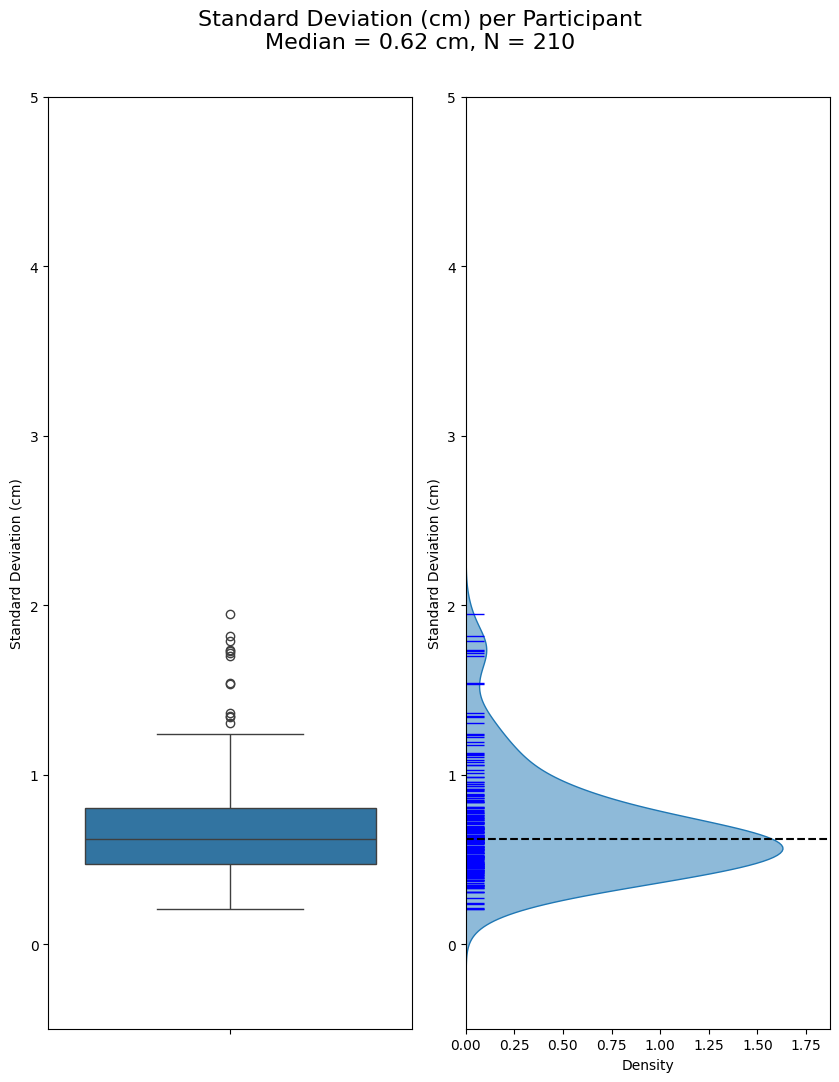

In [22]:
def plot_offset_SD_per_participant(measurement, name=''):
    fig, axes = plt.subplots(1, 2, figsize=(8.5, 11))
    
    median_value = measurement.median()
    
    # KDE Plot with individual data points (rug plot)
    sns.kdeplot(y=measurement, ax=axes[1], fill=True, alpha=0.5)
    sns.rugplot(y=measurement, ax=axes[1], height=0.05, color="b")
    axes[1].axhline(median_value, color='k', linestyle='--', linewidth=1.5, label=f'Median: {median_value:.2f}')
    
    # Boxplot
    sns.boxplot(y=measurement, ax=axes[0])
    
    # Set consistent y-axis limits and labels
    for ax in axes:
        ax.set_ylim(-0.5, 5)
        ax.set_ylabel(name)
        
    fig.suptitle(f'{name} per Participant\nMedian = {median_value:.2f} cm, N = {all_df.subj_nr.nunique()}', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    
    # Uncomment the line below to save the plot
    # fig.savefig(f'{name}_summary.jpg', dpi=1000)

# Prepare summary data across subjects
summary_data = []

# Calculate metrics for each subject and unique dot
for _, group in all_df.groupby(['subj_nr', 'unique_dot']):
    # Compute median gaze for each unique dot
    median_x = group['user_pred_px_x_scaled'].median()
    median_y = group['user_pred_px_y_scaled'].median()
    
    # Compute Euclidean distances
    gaze_coords = group[['user_pred_px_x_scaled', 'user_pred_px_y_scaled']].to_numpy()
    median_coords = np.array([median_x, median_y])
    
    # Distance from gaze samples to median gaze (precision)
    group['eucl_dist_gaze_to_median_px'] = np.linalg.norm(gaze_coords - median_coords, axis=1)
    group['eucl_dist_gaze_to_median_cm'] = group['eucl_dist_gaze_to_median_px'] * all_df['scale_cm_in_px'].iloc[0]
    
    # Offset from median gaze to ground truth (accuracy)
    ground_truth_coords = group[['x_scaled', 'y_scaled']].to_numpy()
    group['offset_px'] = np.linalg.norm(median_coords - ground_truth_coords, axis=1)
    group['offset_cm'] = group['offset_px'] * all_df['scale_cm_in_px'].iloc[0]
    
    summary_data.append(group)

# Combine data across all subjects and calculate mean precision (SD) and accuracy (offset)
summary_df = pd.concat(summary_data)
agg_SD = summary_df.groupby('subj_nr')['eucl_dist_gaze_to_median_cm'].mean().reset_index()
agg_OFFSET = summary_df.groupby('subj_nr')['offset_cm'].mean().reset_index()

# Plot offset and SD per subject
plot_offset_SD_per_participant(agg_OFFSET['offset_cm'], name='Offset (cm)')
plot_offset_SD_per_participant(agg_SD['eucl_dist_gaze_to_median_cm'], name='Standard Deviation (cm)')

# Combine all data across conditions for final summary
summary_df_all = pd.concat([summary_df])


In [23]:
# Participant descriptive statistics (gaze samples per participant)
descr_stats = summary_df_all.groupby(['subj_nr', 'pp_id'])['unique_dot'].count().reset_index()
print(f'Descriptive Stats:\n {descr_stats}')

Descriptive Stats:
                  subj_nr    pp_id  unique_dot
0    2024_02_19_08_03_20    28861         400
1    2024_02_19_08_03_44    32041         387
2    2024_02_19_08_04_13    31795         395
3    2024_02_19_08_14_12    29509         395
4    2024_02_19_08_43_42    36313         388
..                   ...      ...         ...
205  2024_03_14_10_26_10    32224         407
206  2024_03_15_08_14_16    36958         404
207  2024_03_15_08_42_43    28672         397
208  2024_03_15_08_53_54    30790         401
209  2024_03_15_11_15_54  31192.0         397

[210 rows x 3 columns]


In [21]:
# Participant descriptive statistics (gaze samples per participant)
descr_stats2 = summary_df_all.groupby(['subj_nr','unique_dot'])['offset_cm'].count().reset_index()
descr_stats3 = descr_stats2.groupby(['subj_nr']).unique_dot.count().reset_index()
print(f'Mean unique dots:\n {descr_stats3}')

Mean unique dots:
                  subj_nr  unique_dot
0    2024_02_19_08_03_20           9
1    2024_02_19_08_03_44           9
2    2024_02_19_08_04_13           9
3    2024_02_19_08_14_12           9
4    2024_02_19_08_43_42           9
..                   ...         ...
205  2024_03_14_10_26_10           9
206  2024_03_15_08_14_16           9
207  2024_03_15_08_42_43           9
208  2024_03_15_08_53_54           9
209  2024_03_15_11_15_54           9

[210 rows x 2 columns]


C:\Users\aby600\AppData\Local\Temp\ipykernel_17432\4047861623.py:18: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='unique_dot', y='offset_cm', data=summary_df, inner='point', cut=0, scale='width')


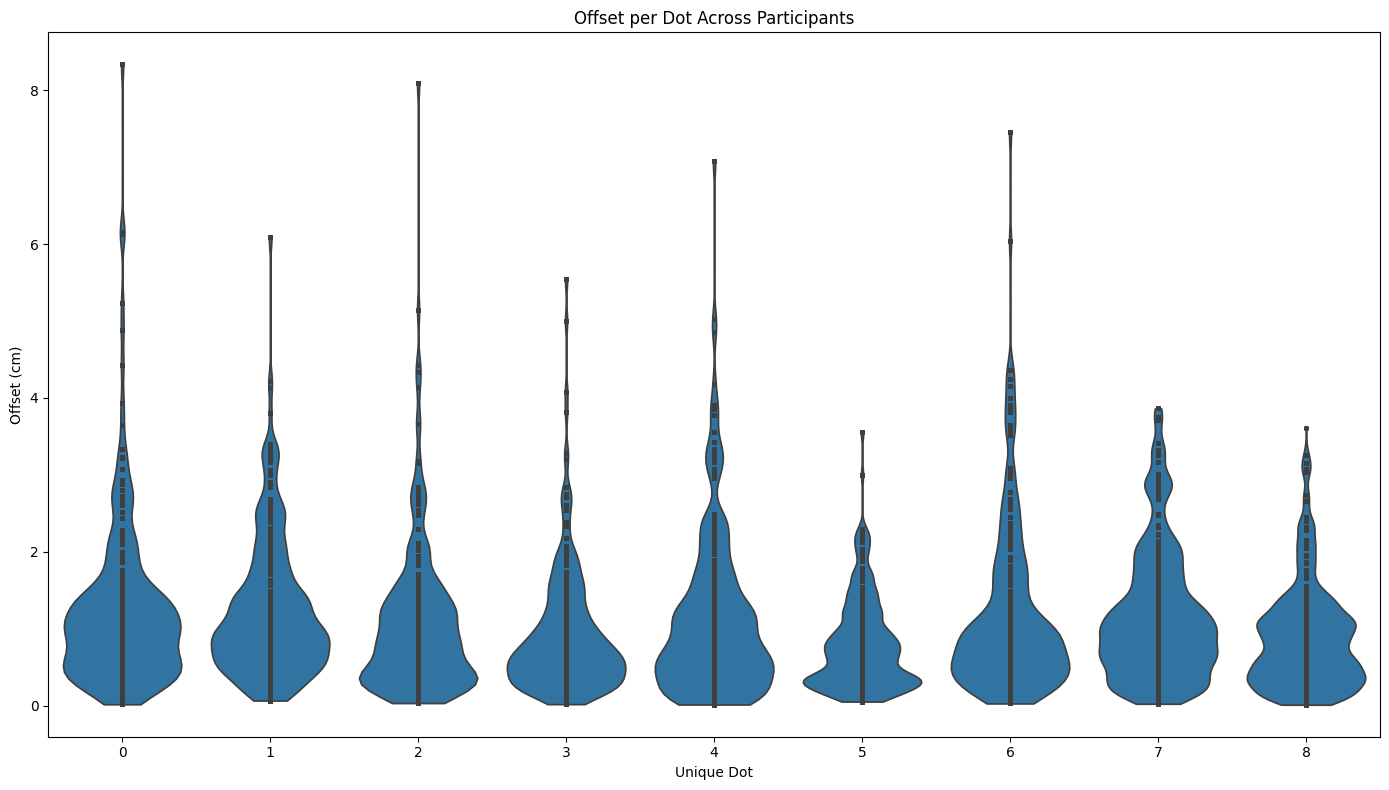

C:\Users\aby600\AppData\Local\Temp\ipykernel_17432\4047861623.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='unique_dot', y='offset_cm', data=summary_df, palette="Set3")


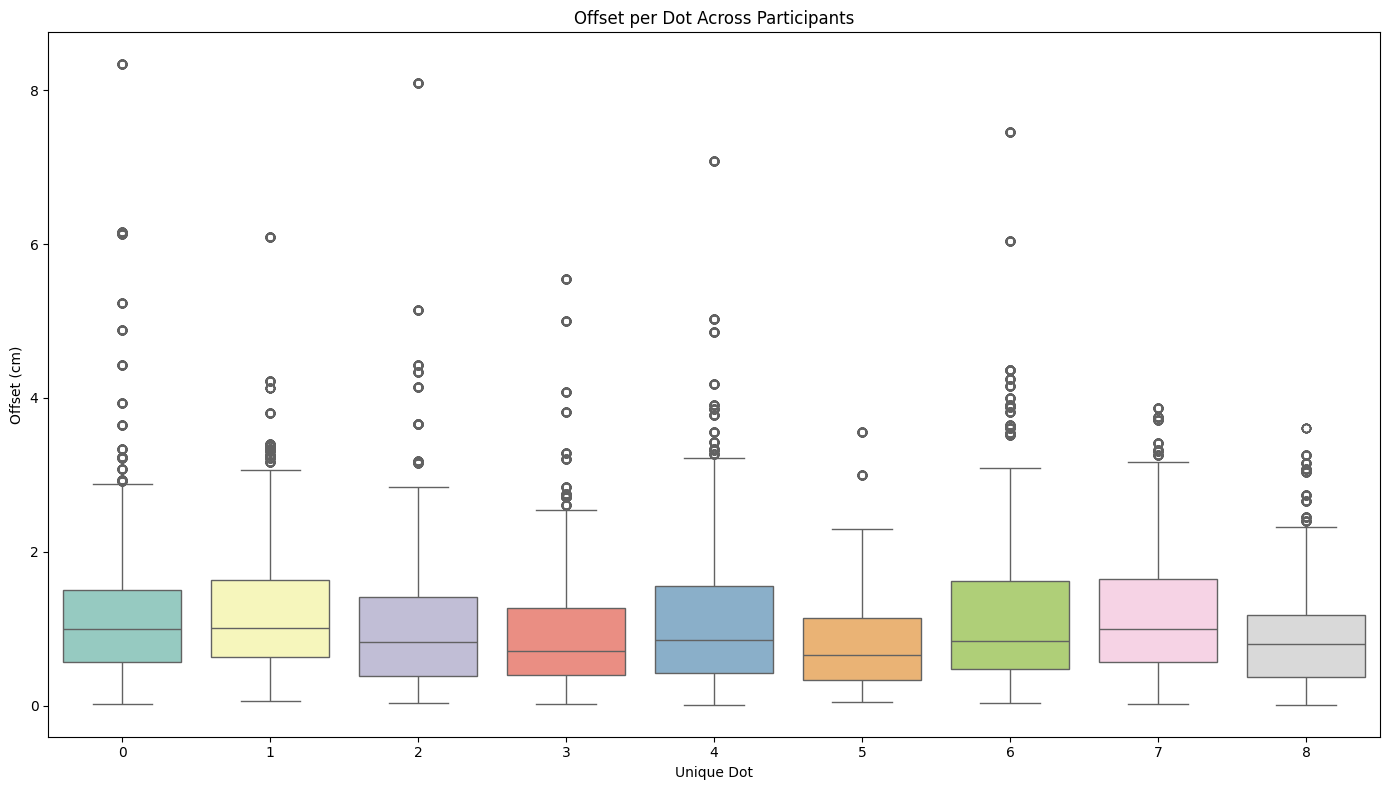

In [28]:
def plot_offset_per_dot(summary_df, scale_factor, plot_type='violin'):
    """
    Plots offset across participants for each dot.
    
    Parameters:
    - summary_df (pd.DataFrame): Dataframe containing offset data for each dot and participant.
    - scale_factor (float): Scaling factor to convert offsets to cm.
    - plot_type (str): Type of plot - 'violin' for a violin plot, 'swarm' for a swarm plot.
    """
    # Set up the figure and axis
    plt.figure(figsize=(14, 8))
    
    # Apply scaling factor to convert to cm if necessary
    summary_df['offset_cm'] = summary_df['offset_px'] * scale_factor
    
    # Choose the plot type
    if plot_type == 'violin':
        sns.violinplot(x='unique_dot', y='offset_cm', data=summary_df, inner='point', cut=0, scale='width')
    elif plot_type == 'swarm':
        # sns.swarmplot(x='unique_dot', y='offset_cm', data=summary_df, color='b', alpha=0.6)
        # sns.stripplot(x='unique_dot', y='offset_cm', data=summary_df, color='b', alpha=0.6, jitter=True)
        sns.boxplot(x='unique_dot', y='offset_cm', data=summary_df, palette="Set3")
    else:
        print("Unsupported plot type. Choose 'violin' or 'swarm'.")
        return
    
    # Set labels and title
    plt.xlabel('Unique Dot')
    plt.ylabel('Offset (cm)')
    plt.title('Offset per Dot Across Participants')
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Call the function 
plot_offset_per_dot(summary_df_all, all_df['scale_cm_in_px'].iloc[0], plot_type='violin')
plot_offset_per_dot(summary_df_all, all_df['scale_cm_in_px'].iloc[0], plot_type='swarm')



In [5]:
# Path to data folders
path_to_folders = 'C:/Users/aby600/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/data'
# path_to_folders = 'D:/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/data'


# get all folder names
folder_names = os.listdir(path_to_folders)

pp_list = []
num_calib_attemtps = []
for fn in folder_names:
    path = os.path.join(path_to_folders, fn, fn+'_test_all.csv')       
        
    try: 
        # Read CSV file, ensuring that bad rows are handled by ignoring them
        df = pd.read_csv(path)
        
    except:
        continue
    
    
    # Find the headers via duplicates and use it to split into datasets   
    mask_dup = df.duplicated(keep=False)
    # Make indices of datasets
    idx_dup = df.index[mask_dup == True].tolist()
    idx_dup[:0] = [-1] # add lower index
    idx_dup.extend([df.shape[0]]) # add upper index
    
    # Use indices to parse datasets
    df_list = []
    count_datasets = 0
    last_numCalibDots = []
    
    for i in range(len(idx_dup)):
        if i < len(idx_dup) - 1:
            a = df.iloc[idx_dup[i]+1:idx_dup[i+1]]
            a = a.apply(pd.to_numeric, errors='coerce') # when header is written twice, some floats are str, fix this
            a.dropna(subset=['numCalibDots'], inplace=True) # drop rows where numCalibDots = NaN
            a['numCalibDots'] = a['numCalibDots'].astype(int)
            a['dataset_num'] = count_datasets
            

            a['eucl_dist_px_orig'] = np_euclidean_distance(np.array(a[['x','y']]), np.array(a[['user_pred_px_x','user_pred_px_y']]))
            scale_cm_in_px = a.scrW_cm/a.resX
            a['eucl_dist_cm_orig'] = a.eucl_dist_px_orig * scale_cm_in_px 
                                  
           
            a['condition'] = a.numCalibDots.astype(str)
                
            last_numCalibDots.append(a.numCalibDots.iloc[-1]) # log last value                
            
            # Accumulate all dataset per subject
            df_list.append(a)
            count_datasets += 1
    
    
    # if there are more than 4 datasets, remove the recalibrated ones, pick the last one
    last_numCalibDots = pd.Series(last_numCalibDots)
    idx_good_datasets = last_numCalibDots.loc[last_numCalibDots.shift(-1) != last_numCalibDots] # shift dataset by one row and get indices
    df_list = [df_list[i] for i in list(idx_good_datasets.index)] # pick only the 4 datasets
    # assert(len(df_list) == 4)
    
    # Concatenate all datasets per subject
    b = pd.concat(df_list)
    
    # Add a subj_nr column
    b['subj_nr'] = fn    
    
    # Count the number of calibration attempts per participant in a new df
    unique, counts = np.unique(last_numCalibDots, return_counts=True)
    c = pd.DataFrame(np.asarray((unique, counts)).T, columns=['num_calib_dots', 'frequency'])
    c['subj_nr'] = fn
    num_calib_attemtps.append(c)
    num_calib_attempts_df = pd.concat(num_calib_attemtps).reset_index(drop=True)
    
        
    # Accumulate datasets across subjects
    pp_list.append(b)

# Concatenate all subjects in one df
df_all = pd.concat(pp_list)
df_all = df_all.reset_index()


"""
'2023_04_15_11_42_39' - amazing performance, but did not do 25_9
"""
# Exclude subjects
df_all = df_all[df_all.subj_nr != '2023_04_07_13_59_57'] # my pilot data
df_all = df_all[df_all.subj_nr != '2023_04_07_13_45_47'] # my pilot data

# Convert coordinates to standard resolution (target_resX and target_resY)
# Every display resolution is scaled to this one since all dots are drawn in % display size in px
target_resX = df_all.resX.iloc[0] #1280.0
target_resY = df_all.resY.iloc[0] #800.0

df_all['user_pred_px_x_scaled'] = df_all.user_pred_px_x/df_all.resX * target_resX
df_all['user_pred_px_y_scaled'] = df_all.user_pred_px_y/df_all.resY * target_resY

df_all['x_scaled'] = np.round(df_all.x/df_all.resX * target_resX)
df_all['y_scaled'] = np.round(df_all.y/df_all.resY * target_resY)

# Get an average scale for converting to px to cm
df_all['scale_cm_in_px'] = df_all.scrW_cm.astype(float)/df_all.resX.astype(float)
scale_cm_in_px = df_all.scale_cm_in_px.mean() # average scaling factor

# Get indices of unique dot positions (unique rows)
u, indices = np.unique(np.array([df_all.x_scaled, df_all.y_scaled]).T, axis=0, return_inverse=True)
df_all['unique_dot'] = indices

### Plot heatmaps per each condition
Gaze positions for all subjects are combined

In [ ]:

# Iterate per condition
for name, df in df_all.groupby('condition'):

    # Make heatmap of all gaze points of all subjects
    heatmap = makeHeat([target_resX, target_resY], np.array(df.user_pred_px_x_scaled), np.array(df.user_pred_px_y_scaled))    
    
    # Get median gaze prediction per dot
    median_pred_x = df.groupby('unique_dot').user_pred_px_x_scaled.median()
    median_pred_y = df.groupby('unique_dot').user_pred_px_y_scaled.median()  
             
    # Get ground truth per each dot
    true_x = df.groupby('unique_dot').x_scaled.mean()
    true_y = df.groupby('unique_dot').y_scaled.mean()   
        
    # calculate the distance between median gaze prediction to ground truth per each dot
    offset = np_euclidean_distance(np.array([median_pred_x, median_pred_y]).T, np.array([true_x, true_y]).T)    
   
    # Convert to cm
    offset_cm = offset *  scale_cm_in_px
    
    # Compute SD   
    median_pred = df.groupby('unique_dot')[['user_pred_px_x_scaled','user_pred_px_y_scaled']].median()
    median_pred.columns = ['median_pred_x', 'median_pred_y'] 
    # Add median prediction per dot into the original df
    df = pd.merge(df, median_pred, on="unique_dot", how="left")
    
    # Compute euclidean distance from each gaze sample to median gaze for each dot  
    df['eucl_dist_gaze_to_median_px'] = np_euclidean_distance(np.array([df.user_pred_px_x_scaled, df.user_pred_px_y_scaled]).T, 
                                                             np.array([df.median_pred_x, df.median_pred_y]).T)
    
    # Average e.d. for each dot
    SD = df.groupby('unique_dot').eucl_dist_gaze_to_median_px.mean()
    SD_cm = SD * scale_cm_in_px
    
    # Get subplot coordinates
    # row = subplot_cell[count_plots2][0]
    # column = subplot_cell[count_plots2][1]
    
    # Plot heatmap for current condition
    plt.figure()

    plt.imshow(heatmap, cmap=cm.hot, extent=[0, target_resX, target_resY, 0], alpha = 0.5, aspect='equal')  
    # Plot true pos and predicted median errors, lines
    plt.scatter(df.x_scaled, df.y_scaled, c='g', s=40, alpha=0.5, label='ground truth')
    plt.scatter(median_pred_x, median_pred_y, c='b', s=40, alpha=0.5, label='predicted gaze')
    plt.plot([median_pred_x, true_x], [median_pred_y, true_y], c='black')
    # Title
    plt.title(f'N={df.subj_nr.unique().size}\n Offset: {np.round(offset_cm.mean(),1)}cm, SD:{np.round(SD_cm.mean(),1)}cm')
    
    # Plot offset values for each dot
    for x,y,e in zip(np.array(true_x), np.array(true_y), np.round(offset_cm, 1)):
        plt.text(x, y, e, fontsize=10)
    
    # count_plots2 += 1      
  
    
 # Save plot
plt.suptitle(f'Calibration (all participants)', fontsize=14)
plt.subplots_adjust(top=1.0)
plt.legend(loc='upper right', bbox_to_anchor=(1.1,1.25))
# fig2.savefig('calibration.jpg', dpi=1000, pad_inches=0)

### Calculate and plot offsets and SD per condition per subject

1. Offset - euclidean distance from the median gaze prediction per each dot to the ground truth
2. SD - mean of euclidean distances from each gaze prediction to the median gaze prediction for each dot

In [ ]:
def plot_offset_SD_per_participant(measurement, name=''):

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches((8.5, 11), forward=False)

    sns.kdeplot(y=measurement, ax=ax[1], fill=True, alpha=0.5)
    # Plot individual points
    sns.rugplot(y=measurement, ax=ax[1], height=0.05, color="b")
    median_data = measurement.median()
    plt.axhline(median_data, color='k', linestyle='--', linewidth=1.5, label=f'Median: {median_data:.2f}')
    
    
    sns.boxplot(y=measurement, ax=ax[0])
    
    ax[0].set_ylim(-0.5,5)
    ax[1].set_ylim(-0.5,5)

    # Save plot   
    fig.suptitle(f'{name} per participant\n Median={median_data:.2f}cm, N={df_all.subj_nr.unique().size}', fontsize=16)
    ax[0].set_ylabel(name)
    ax[1].set_ylabel(name)

    fig.tight_layout()    
    fig.subplots_adjust(top=0.9)
    # fig.savefig('summary.jpg', dpi=1000)


# Loop thru each condition
count_plots = 0
summary_df_all = []

for name, i in df_all.groupby('condition'):
    
    # df for all subjects for each condition
    summary_df = []    
   
    # Loop thru each subject and unique dot
    for _, j in i.groupby(['subj_nr', 'unique_dot']):
        
        # Get median gaze for each unique dot in pixels
        j['median_pred_x'] = j.user_pred_px_x_scaled.median()
        j['median_pred_y'] = j.user_pred_px_y_scaled.median()
        
        # Get euclidean distance from each gaze sample to median gaze for each dot
        j['eucl_dist_gaze_to_median_px'] = np_euclidean_distance(np.array([j.user_pred_px_x_scaled, j.user_pred_px_y_scaled]).T, 
                              np.array([j.median_pred_x, j.median_pred_y]).T)        
        j['eucl_dist_gaze_to_median_cm'] = j.eucl_dist_gaze_to_median_px * scale_cm_in_px
        
        # Get euclidean distance from median gaze to ground truth (accuracy)
        j['offset_px'] = np_euclidean_distance(np.array([j.median_pred_x, j.median_pred_y]).T, np.array([j.x_scaled, j.y_scaled]).T)  
        j['offset_cm'] = j.offset_px * scale_cm_in_px
        
        summary_df.append(j)        
    
    # Concatenate datasets from all subjects  
    summary_df = pd.concat(summary_df)
    
    # Get STD (mean distance of gaze_to_median per subject)
    agg_SD = summary_df.groupby(['subj_nr'])[['eucl_dist_gaze_to_median_cm']].mean().reset_index()
    
    # Get offset
    agg_OFFSET = summary_df.groupby(['subj_nr'])[['offset_cm']].mean().reset_index()
    
    # Plot offset per subject 
    plot_offset_SD_per_participant(agg_OFFSET.offset_cm, name='Offset (cm)')

    # Plot SD per subject
    plot_offset_SD_per_participant(agg_SD.eucl_dist_gaze_to_median_cm, name='Standard Deviation (cm)')
      
   
    count_plots += 1
    
    # accumulate all dfs across conditions
    summary_df_all.append(summary_df)

# Concatenate datasets across conditions
summary_df_all = pd.concat(summary_df_all)
    



### Overview of participants and the number of included gaze samples

In [ ]:
# Participant descriptive statistics (gaze samples per participant)
descr_stats = summary_df_all.groupby(['subj_nr', 'pp_id'])['unique_dot'].count().reset_index()
print(f'Descriptive Stats:\n {descr_stats}')

### Average number of unique dots per condition

In [ ]:
# Participant descriptive statistics (gaze samples per participant)
descr_stats = summary_df_all.groupby(['condition','subj_nr','unique_dot'])['offset_cm'].count().reset_index()
descr_stats2 = descr_stats.groupby(['condition', 'subj_nr']).unique_dot.count().reset_index()
descr_stats2 = descr_stats2.groupby('condition').unique_dot.mean()
print(f'Mean unique dots:\n {descr_stats2}')

### How many calibration attempts for 9 and 13 conditions?

In [ ]:
num_calib_attempts_df.groupby('num_calib_dots').frequency.mean()